# Student Performance Predictor

## Project Domain

### Background Problem
Education is a cornerstone of human development, yet challenges like low academic performance and high dropout rates persist. Factors such as socioeconomic background, study habits, and school environment significantly influence student outcomes. Early identification of at-risk students can enable timely interventions to improve their academic success.

The UCI Student Performance Dataset provides a rich set of features related to student demographics, behavioral patterns, and academic history, offering an excellent opportunity to apply predictive analytics.

### Why and How Should This Problem Be Solved?
Addressing academic performance issues is crucial because:

1. Improving Outcomes: Identifying at-risk students early can help schools and educators implement targeted strategies to improve grades and reduce dropout rates.
2. Personalized Interventions: Predictive models can guide personalized support strategies, ensuring better resource allocation.
3. Data-Driven Insights: Analyzing key factors affecting performance enables informed decision-making in the education sector.



## Business Understanding

## Data Understanding

## Exploratory Data Analysis

### Import All Libraries

In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

### Data Loading

In [2]:
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
student_performance = fetch_ucirepo(id=320) 
  
# data (as pandas dataframes) 
df = pd.concat([student_performance.data.features, student_performance.data.targets], axis=1)

# metadata 
print(student_performance.metadata) 


{'uci_id': 320, 'name': 'Student Performance', 'repository_url': 'https://archive.ics.uci.edu/dataset/320/student+performance', 'data_url': 'https://archive.ics.uci.edu/static/public/320/data.csv', 'abstract': 'Predict student performance in secondary education (high school). ', 'area': 'Social Science', 'tasks': ['Classification', 'Regression'], 'characteristics': ['Multivariate'], 'num_instances': 649, 'num_features': 30, 'feature_types': ['Integer'], 'demographics': ['Sex', 'Age', 'Other', 'Education Level', 'Occupation'], 'target_col': ['G1', 'G2', 'G3'], 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 2008, 'last_updated': 'Fri Jan 05 2024', 'dataset_doi': '10.24432/C5TG7T', 'creators': ['Paulo Cortez'], 'intro_paper': {'ID': 360, 'type': 'NATIVE', 'title': 'Using data mining to predict secondary school student performance', 'authors': 'P. Cortez, A. M. G. Silva', 'venue': 'Proceedings of 5th Annual Future Business Technolo

In [3]:
# variable information 
print(student_performance.variables) 

          name     role         type      demographic  \
0       school  Feature  Categorical             None   
1          sex  Feature       Binary              Sex   
2          age  Feature      Integer              Age   
3      address  Feature  Categorical             None   
4      famsize  Feature  Categorical            Other   
5      Pstatus  Feature  Categorical            Other   
6         Medu  Feature      Integer  Education Level   
7         Fedu  Feature      Integer  Education Level   
8         Mjob  Feature  Categorical       Occupation   
9         Fjob  Feature  Categorical       Occupation   
10      reason  Feature  Categorical             None   
11    guardian  Feature  Categorical             None   
12  traveltime  Feature      Integer             None   
13   studytime  Feature      Integer             None   
14    failures  Feature      Integer             None   
15   schoolsup  Feature       Binary             None   
16      famsup  Feature       B

In [4]:
# Load datasets
math_df = pd.read_csv("student/student-mat.csv", sep=";")
por_df = pd.read_csv("student/student-por.csv", sep=";")

# Define merge columns (key columns)
merge_columns = ["school", "sex", "age", "address", "famsize", "Pstatus", "Medu", "Fedu", 
                 "Mjob", "Fjob", "reason", "nursery", "internet"]

# Merge the datasets
merge_df = pd.merge(por_df, math_df,  on=merge_columns, suffixes=('_math', '_por'))

# Identify the unique columns
# Keep key columns and the non-key columns from the math_df dataset (with '_math' suffix)
unique_columns = merge_columns + [col for col in merge_df.columns if col.endswith('_math')]

# Rename columns to remove '_math' suffix
merge_df = merge_df[unique_columns]
merge_df.columns = [col.replace('_math', '') for col in merge_df.columns]

# Print the resulting DataFrame's shape
merge_df


,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,3,4,1,1,3,4,0,11,11
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,5,3,3,1,1,3,2,9,11,11
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,4,3,2,2,3,3,6,12,13,12
3,GP,F,15,U,GT3,T,4,2,health,services,...,3,2,2,1,1,5,0,14,14,14
4,GP,F,16,U,GT3,T,3,3,other,other,...,4,3,2,1,2,5,0,11,13,13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
377,MS,F,19,R,GT3,T,2,3,services,other,...,5,4,2,1,2,5,4,10,11,10
378,MS,F,18,U,LE3,T,3,1,teacher,services,...,4,3,4,1,1,1,4,15,15,16
379,MS,F,18,U,GT3,T,1,1,other,other,...,1,1,1,1,1,5,6,11,12,9
380,MS,M,17,U,LE3,T,3,1,services,services,...,2,4,5,3,4,2,6,10,10,10


In [5]:
# basic information
merge_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 382 entries, 0 to 381
Data columns (total 33 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   school      382 non-null    object
 1   sex         382 non-null    object
 2   age         382 non-null    int64 
 3   address     382 non-null    object
 4   famsize     382 non-null    object
 5   Pstatus     382 non-null    object
 6   Medu        382 non-null    int64 
 7   Fedu        382 non-null    int64 
 8   Mjob        382 non-null    object
 9   Fjob        382 non-null    object
 10  reason      382 non-null    object
 11  nursery     382 non-null    object
 12  internet    382 non-null    object
 13  guardian    382 non-null    object
 14  traveltime  382 non-null    int64 
 15  studytime   382 non-null    int64 
 16  failures    382 non-null    int64 
 17  schoolsup   382 non-null    object
 18  famsup      382 non-null    object
 19  paid        382 non-null    object
 20  activities

### Initial Inspection

In [6]:
print("Dataset Information: ")
print(df.info())

Dataset Information: 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 649 entries, 0 to 648
Data columns (total 33 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   school      649 non-null    object
 1   sex         649 non-null    object
 2   age         649 non-null    int64 
 3   address     649 non-null    object
 4   famsize     649 non-null    object
 5   Pstatus     649 non-null    object
 6   Medu        649 non-null    int64 
 7   Fedu        649 non-null    int64 
 8   Mjob        649 non-null    object
 9   Fjob        649 non-null    object
 10  reason      649 non-null    object
 11  guardian    649 non-null    object
 12  traveltime  649 non-null    int64 
 13  studytime   649 non-null    int64 
 14  failures    649 non-null    int64 
 15  schoolsup   649 non-null    object
 16  famsup      649 non-null    object
 17  paid        649 non-null    object
 18  activities  649 non-null    object
 19  nursery     649 non-null    

In [7]:
print("Descriptive Statistics:")
print(df.describe())

Descriptive Statistics:
              age        Medu        Fedu  traveltime   studytime    failures  \
count  649.000000  649.000000  649.000000  649.000000  649.000000  649.000000   
mean    16.744222    2.514638    2.306626    1.568567    1.930663    0.221880   
std      1.218138    1.134552    1.099931    0.748660    0.829510    0.593235   
min     15.000000    0.000000    0.000000    1.000000    1.000000    0.000000   
25%     16.000000    2.000000    1.000000    1.000000    1.000000    0.000000   
50%     17.000000    2.000000    2.000000    1.000000    2.000000    0.000000   
75%     18.000000    4.000000    3.000000    2.000000    2.000000    0.000000   
max     22.000000    4.000000    4.000000    4.000000    4.000000    3.000000   

           famrel    freetime       goout        Dalc        Walc      health  \
count  649.000000  649.000000  649.000000  649.000000  649.000000  649.000000   
mean     3.930663    3.180277    3.184900    1.502311    2.280431    3.536210   
std

In [8]:
print("Missing Values:")
print(df.isnull().sum())

Missing Values:
school        0
sex           0
age           0
address       0
famsize       0
Pstatus       0
Medu          0
Fedu          0
Mjob          0
Fjob          0
reason        0
guardian      0
traveltime    0
studytime     0
failures      0
schoolsup     0
famsup        0
paid          0
activities    0
nursery       0
higher        0
internet      0
romantic      0
famrel        0
freetime      0
goout         0
Dalc          0
Walc          0
health        0
absences      0
G1            0
G2            0
G3            0
dtype: int64


### Univariate Analysis

#### Categorical Columns

In [9]:
categorical_columns = df.select_dtypes(include=['object', 'category']).columns

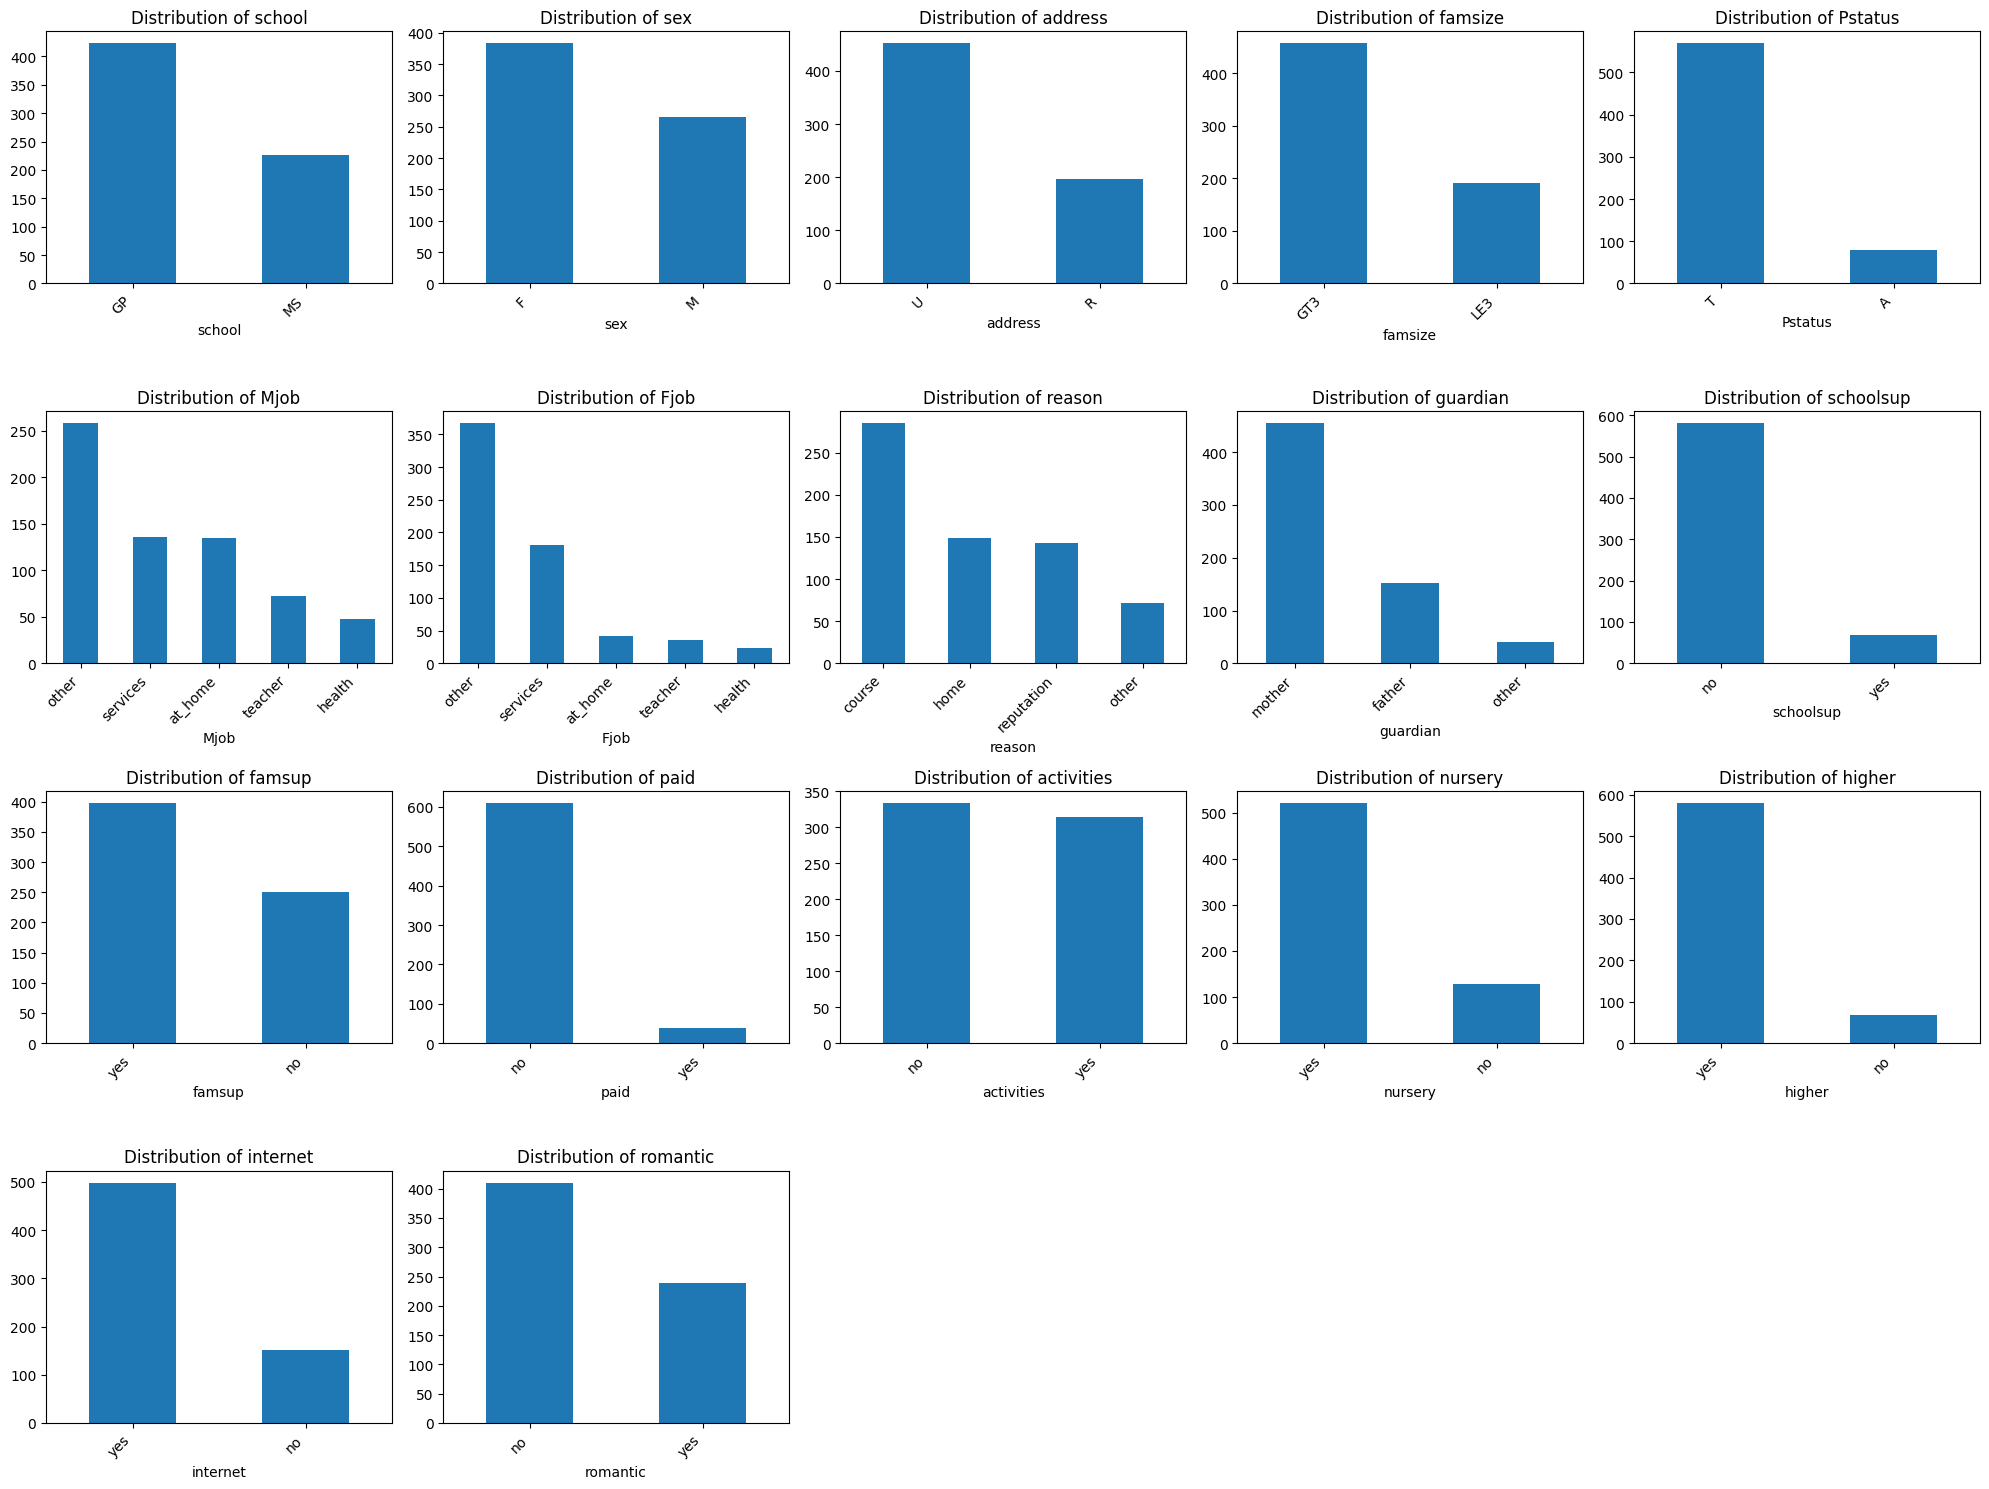

In [10]:
plt.figure(figsize=(20, 15))
for i, col in enumerate(categorical_columns, 1):
    plt.subplot(4, 5, i)
    df[col].value_counts().plot(kind='bar')
    plt.title(f'Distribution of {col}')
    plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

#### Numerical Columns

In [11]:
numerical_columns = df.select_dtypes(include=['int64', 'float64']).columns

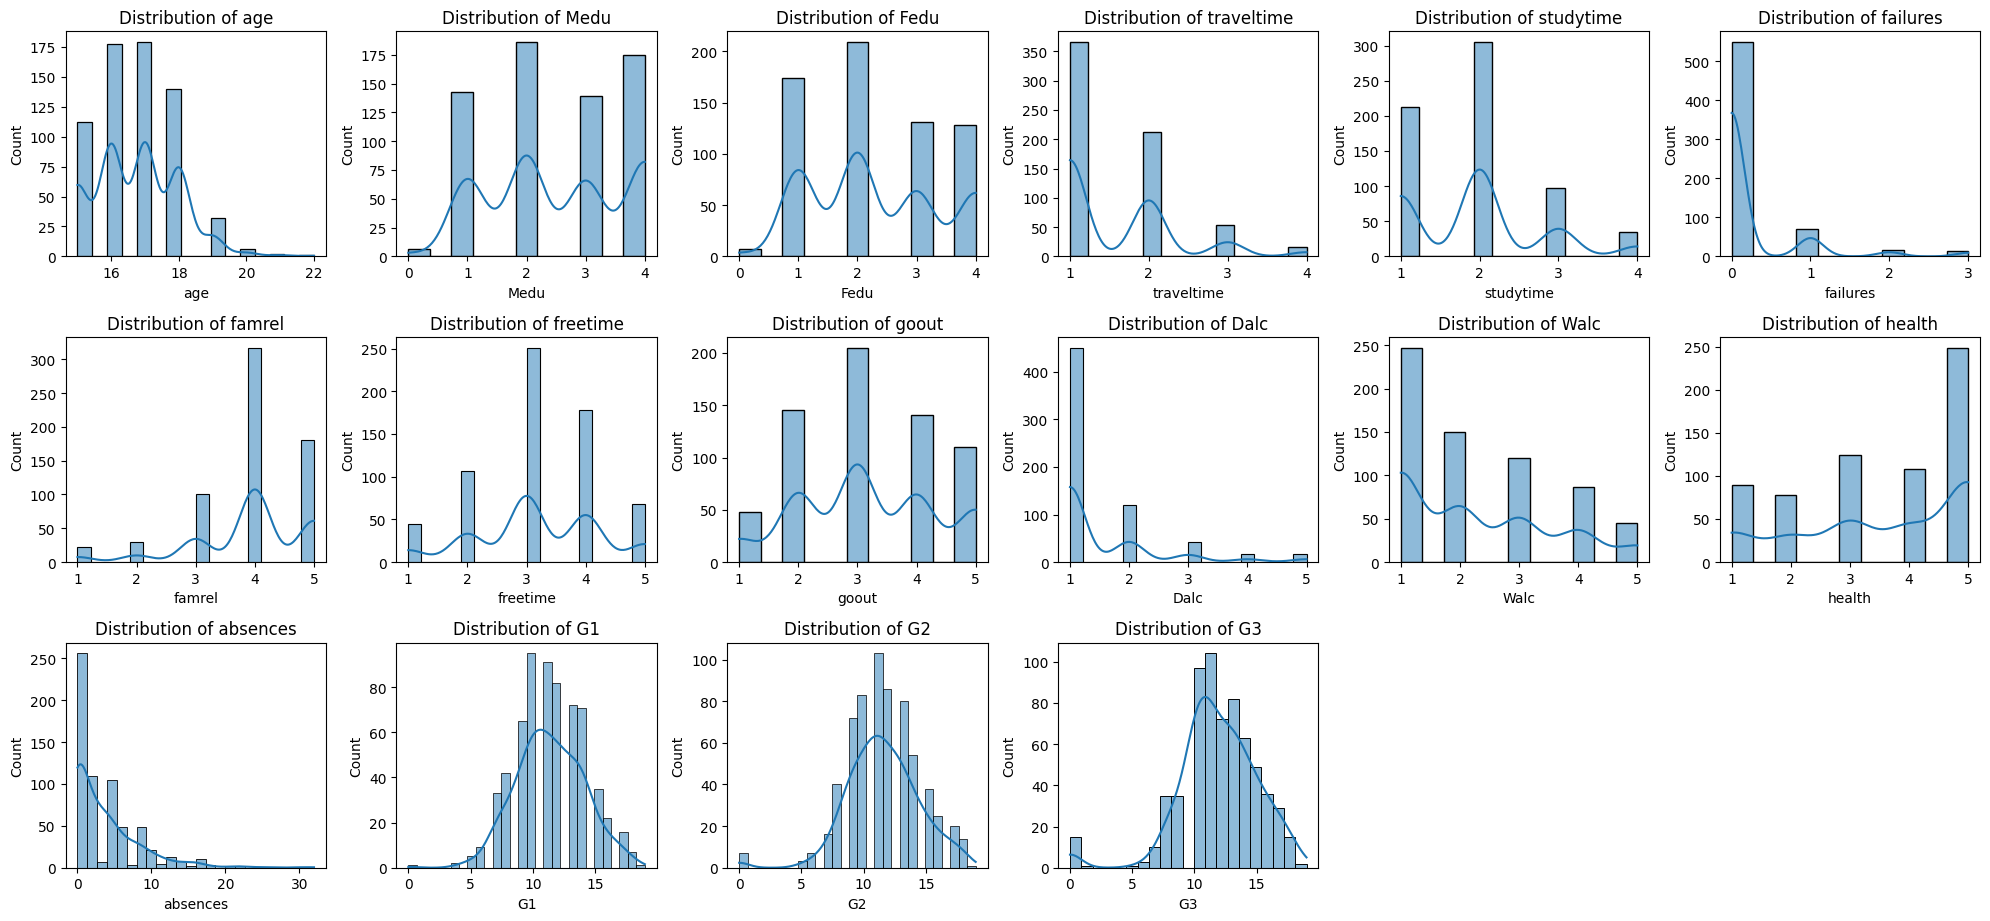

In [12]:
plt.figure(figsize=(20,15))
for i, col in enumerate(numerical_columns, 1):
    plt.subplot(5, 6, i)
    sns.histplot(df[col], kde=True)
    plt.title(f'Distribution of {col}')
plt.tight_layout()
plt.show()

### Multivariate Analysis

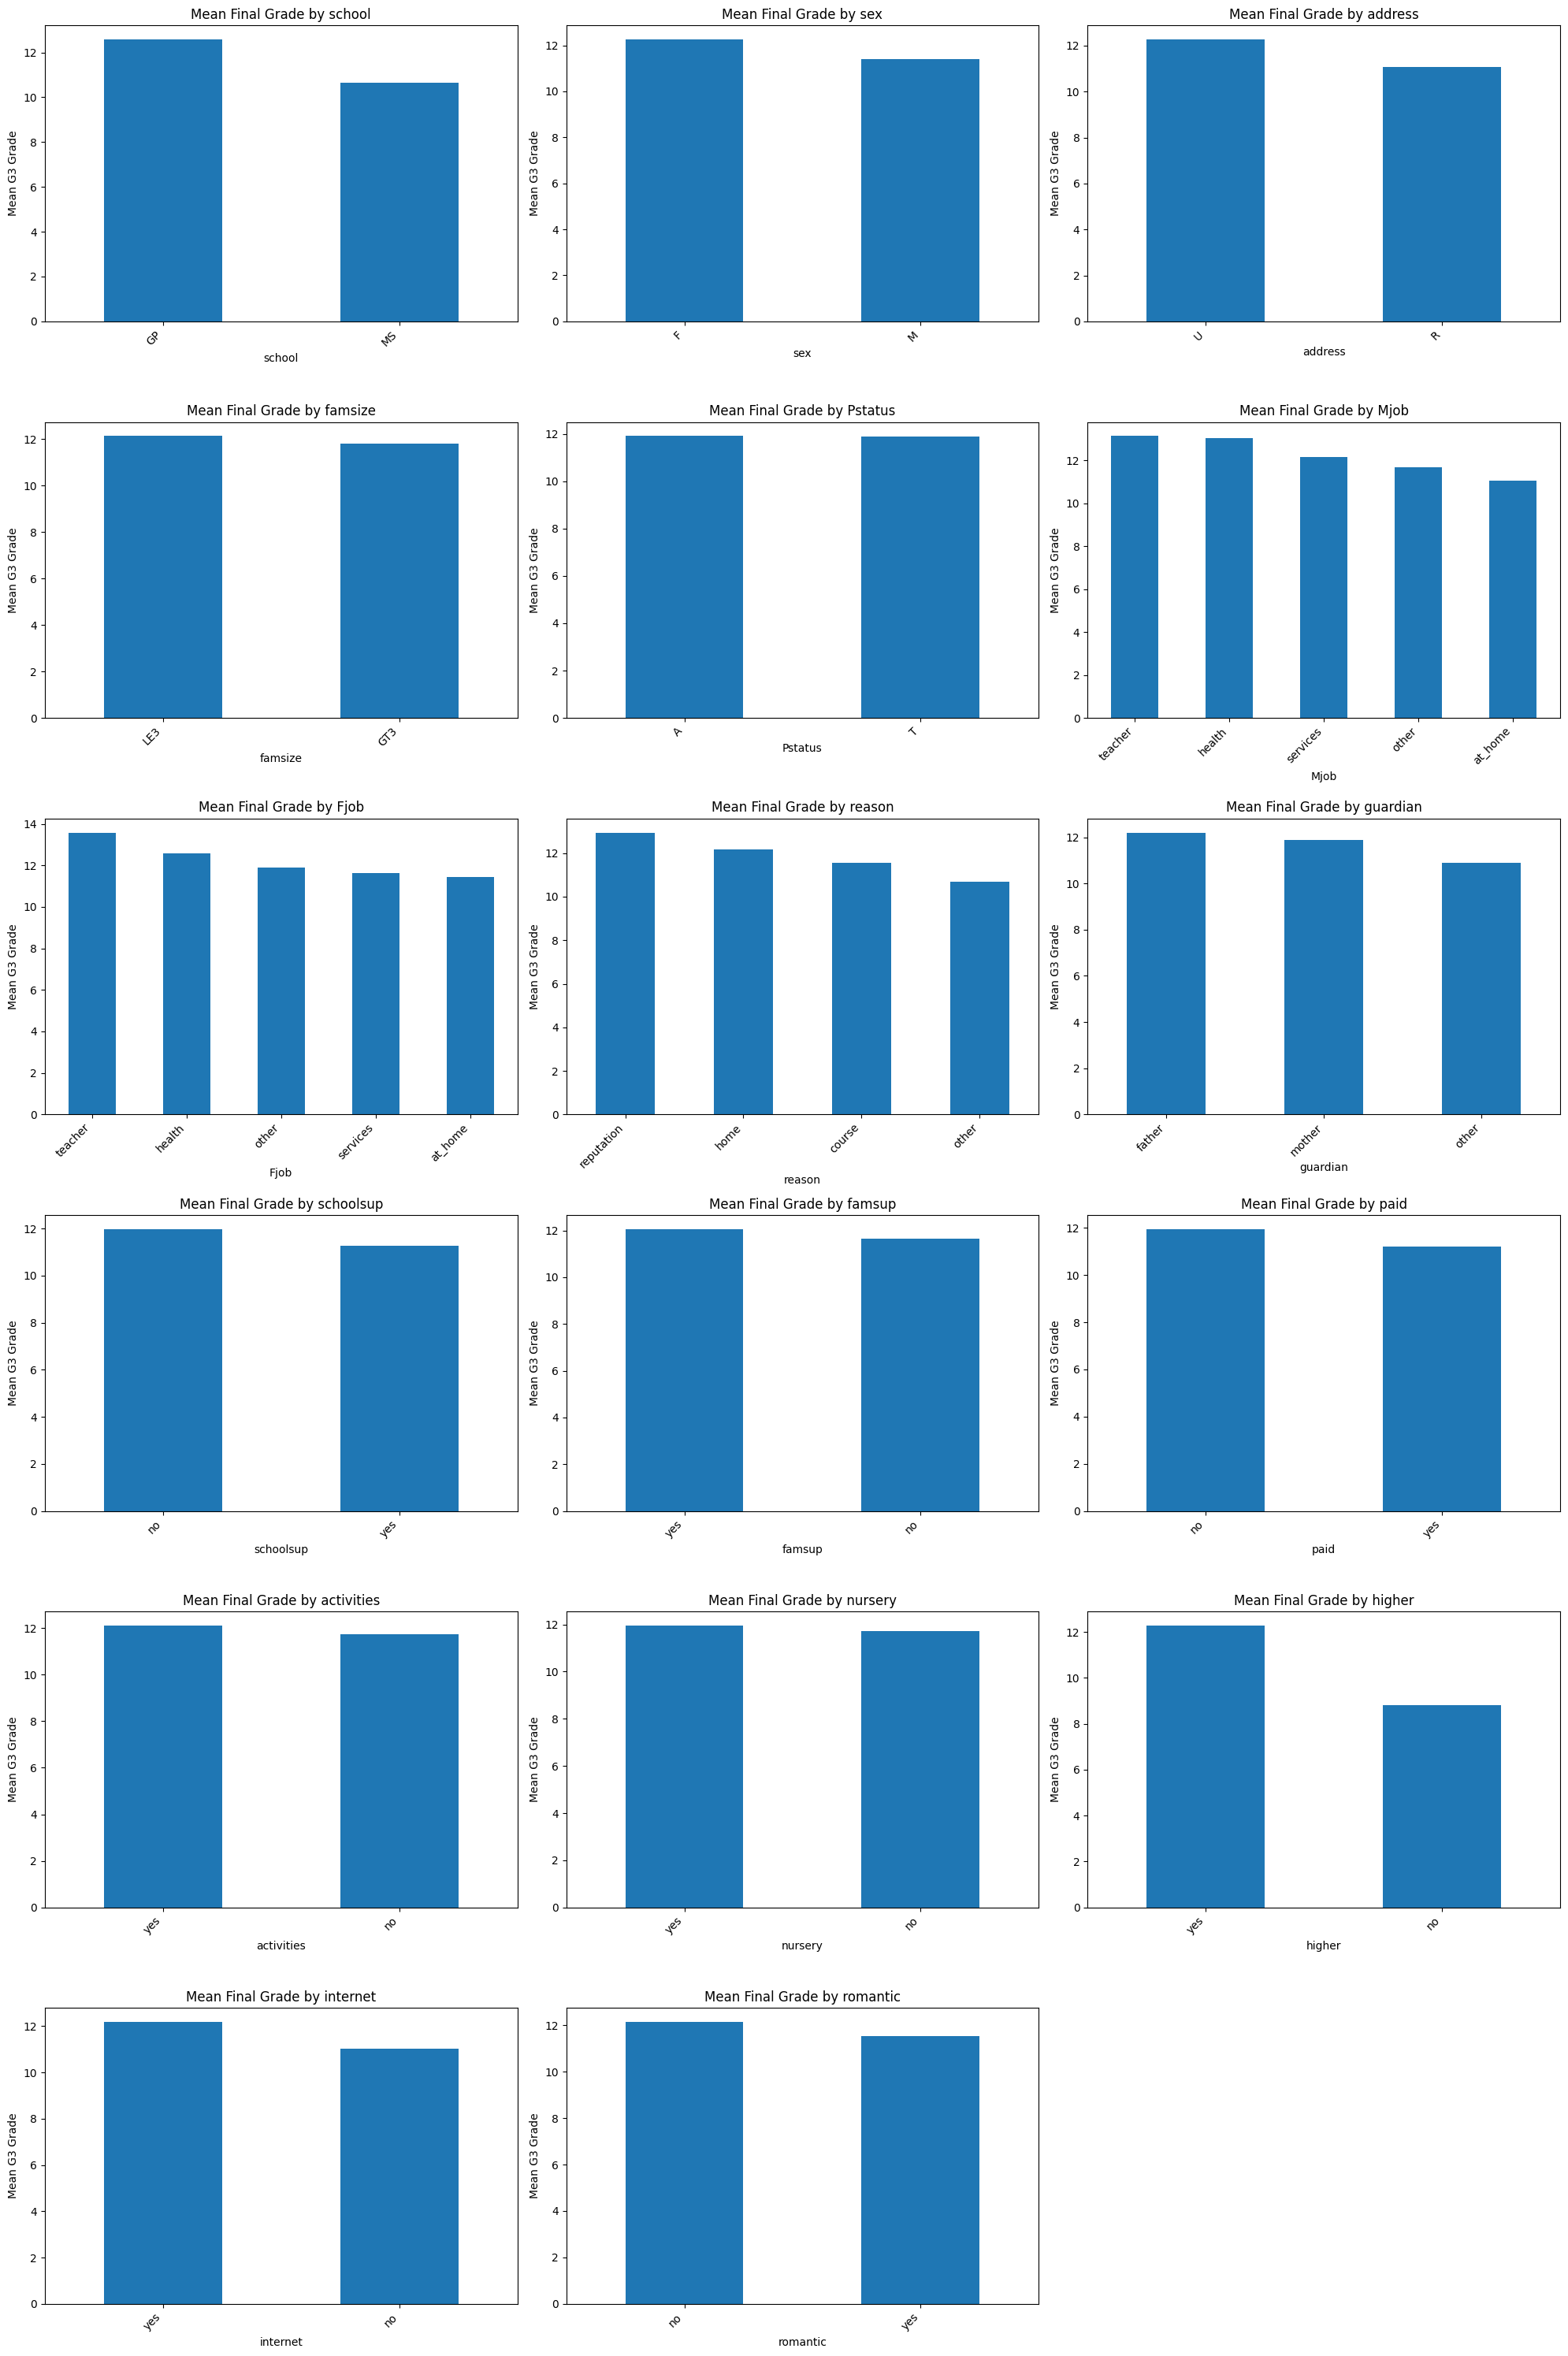

Statistical Summary of Final Grade by Categorical Features:

school Categories:
             mean  median  count
school                          
GP      12.576832    13.0    423
MS      10.650442    11.0    226

sex Categories:
          mean  median  count
sex                          
F    12.253264    12.0    383
M    11.406015    11.0    266

address Categories:
              mean  median  count
address                          
U        12.263274    12.0    452
R        11.086294    11.0    197

famsize Categories:
              mean  median  count
famsize                          
LE3      12.130208    12.0    192
GT3      11.811816    12.0    457

Pstatus Categories:
              mean  median  count
Pstatus                          
A        11.912500    12.0     80
T        11.905097    12.0    569

Mjob Categories:
               mean  median  count
Mjob                              
teacher   13.138889    13.0     72
health    13.062500    13.0     48
services  12.147059   

In [13]:
# Categorical vs G3
# Prepare the plot grid
num_columns = 3
num_rows = (len(categorical_columns) + num_columns - 1) // num_columns

plt.figure(figsize=(20, 5 * num_rows))

# Iterate through categorical columns
for i, col in enumerate(categorical_columns, 1):
    plt.subplot(num_rows, num_columns, i)
    
    # Calculate mean G3 for each category
    category_g3_means = df.groupby(col)['G3'].mean().sort_values(ascending=False)
    
    # Create a bar plot
    category_g3_means.plot(kind='bar')
    plt.title(f'Mean Final Grade by {col}')
    plt.xlabel(col)
    plt.ylabel('Mean G3 Grade')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()

plt.tight_layout()
plt.show()

# Statistical summary of G3 for each categorical variable
print("Statistical Summary of Final Grade by Categorical Features:")
for col in categorical_columns:
    print(f"\n{col} Categories:")
    print(df.groupby(col)['G3'].agg(['mean', 'median', 'count']).sort_values('mean', ascending=False))

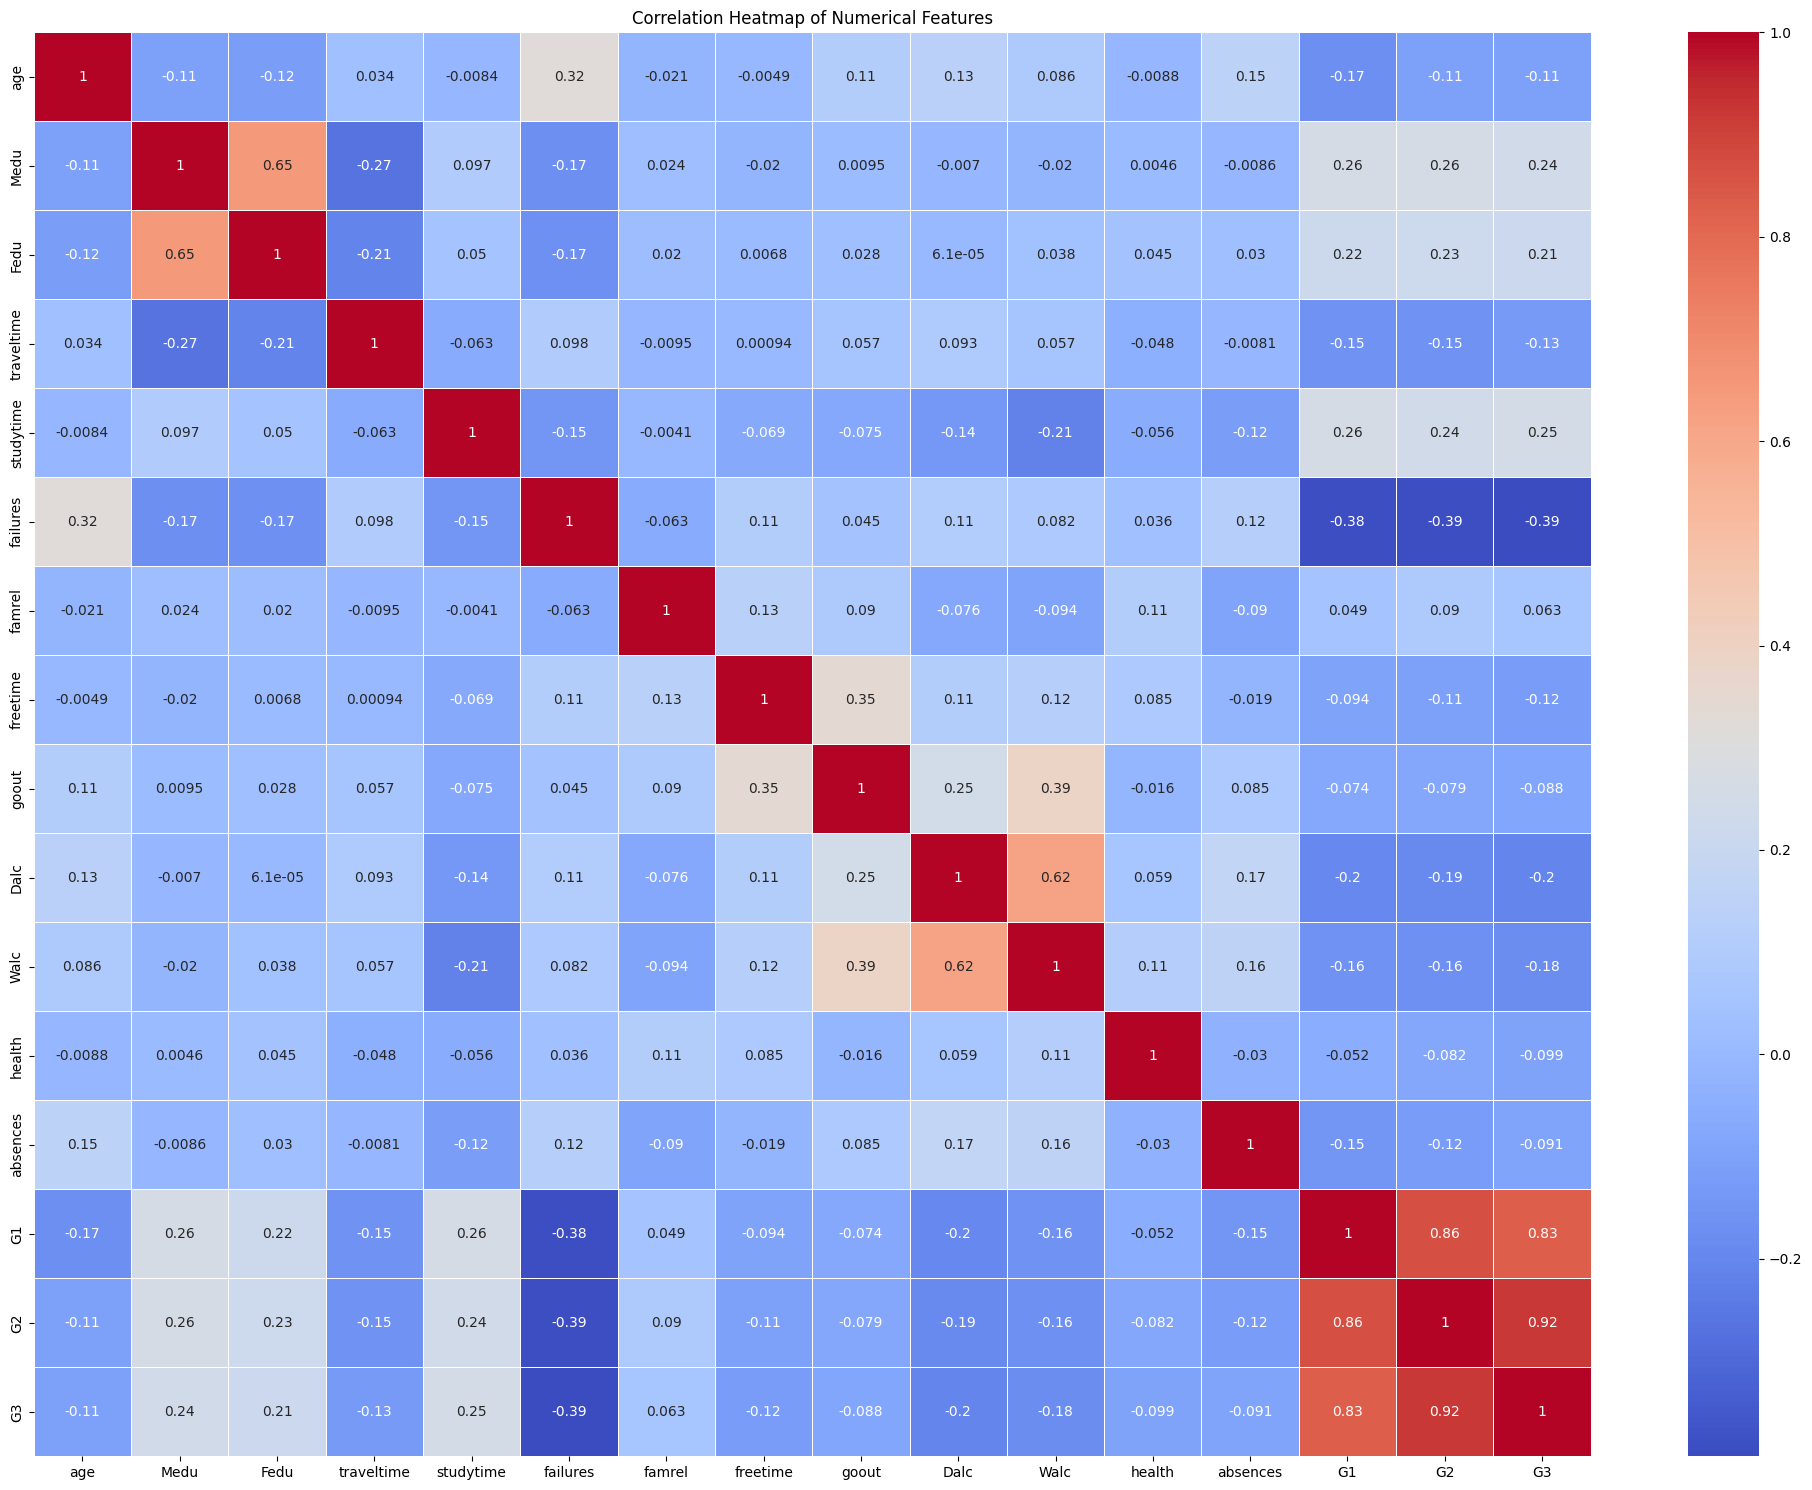

In [14]:
# Correlation Heatmap for Numerical Features
numerical_columns = df.select_dtypes(include=['int64', 'float64']).columns
plt.figure(figsize=(20,15))
correlation_matrix = df[numerical_columns].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap of Numerical Features')
plt.tight_layout()
plt.show()

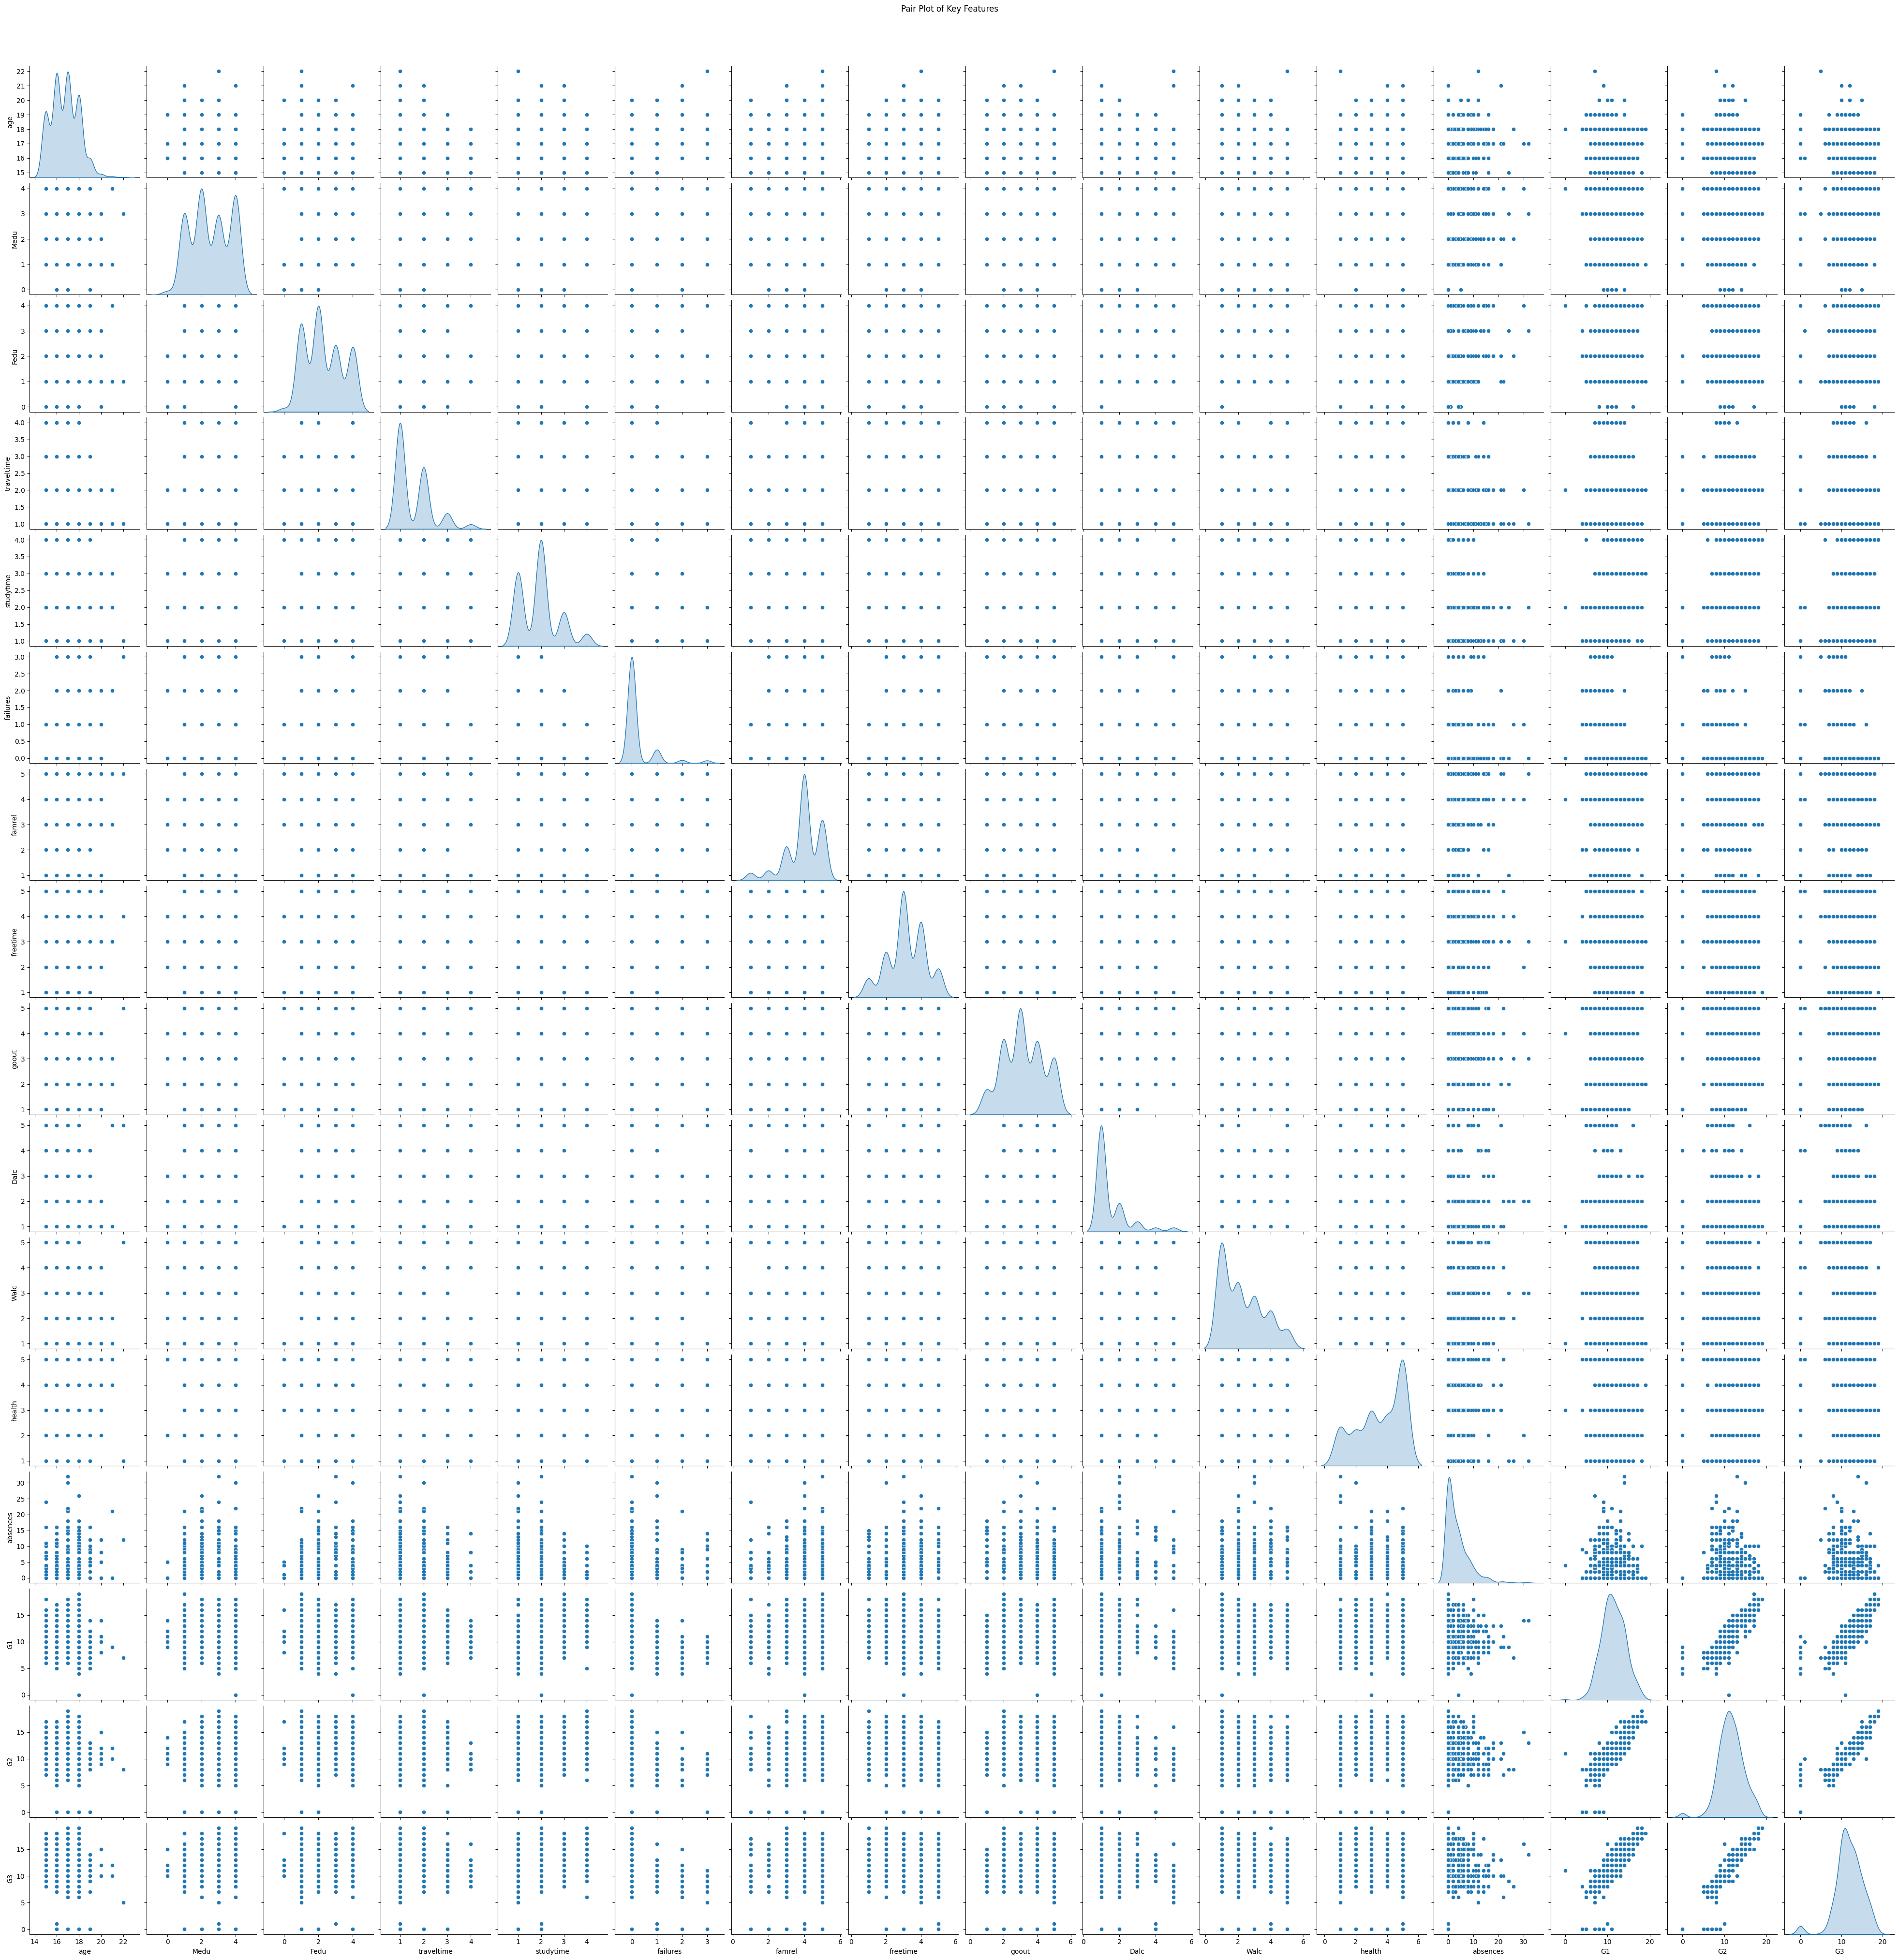

In [15]:
# Pair Plot for Key Numerical Features
sns.pairplot(df[numerical_columns], diag_kind='kde')
plt.suptitle('Pair Plot of Key Features', y=1.02)
plt.show()

## Data Preparation

### Encoding Category Features

In [16]:
categorical_columns

Index(['school', 'sex', 'address', 'famsize', 'Pstatus', 'Mjob', 'Fjob',
       'reason', 'guardian', 'schoolsup', 'famsup', 'paid', 'activities',
       'nursery', 'higher', 'internet', 'romantic'],
      dtype='object')

In [17]:
# Encode categorical columns
for col in categorical_columns:
    df = pd.concat([df, pd.get_dummies(df[col], prefix=col)], axis=1)

df.drop(categorical_columns, axis=1, inplace=True)
# Display the result
print(df.head())

   age  Medu  Fedu  traveltime  studytime  failures  famrel  freetime  goout  \
0   18     4     4           2          2         0       4         3      4   
1   17     1     1           1          2         0       5         3      3   
2   15     1     1           1          2         0       4         3      2   
3   15     4     2           1          3         0       3         2      2   
4   16     3     3           1          2         0       4         3      2   

   Dalc  ...  activities_no  activities_yes  nursery_no  nursery_yes  \
0     1  ...           True           False       False         True   
1     1  ...           True           False        True        False   
2     2  ...           True           False       False         True   
3     1  ...          False            True       False         True   
4     1  ...           True           False       False         True   

   higher_no  higher_yes  internet_no  internet_yes  romantic_no  romantic_yes  
0    

### Train Test Split

In [20]:
from sklearn.model_selection import train_test_split

X = df.drop(['G3'], axis=1)
y = df['G3']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 123)

In [22]:
print(f'Total of sample in whole dataset: {len(X)}')
print(f'Total of sample in train dataset: {len(X_train)}')
print(f'Total of sample in test dataset: {len(X_test)}')

Total of sample in whole dataset: 649
Total of sample in train dataset: 519
Total of sample in test dataset: 130


### Standardization

In [23]:
numerical_columns

Index(['age', 'Medu', 'Fedu', 'traveltime', 'studytime', 'failures', 'famrel',
       'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences', 'G1', 'G2',
       'G3'],
      dtype='object')

In [28]:
numerical_columns = ['age', 'Medu', 'Fedu', 'traveltime', 'studytime', 'failures', 'famrel',
       'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences']
scaler = StandardScaler()
scaler.fit(X_train[numerical_columns])

# Transform the training and test data
X_train[numerical_columns] = scaler.transform(X_train.loc[:, numerical_columns])

X_train.head()

,age,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,Dalc,...,activities_no,activities_yes,nursery_no,nursery_yes,higher_no,higher_yes,internet_no,internet_yes,romantic_no,romantic_yes
243,0.198134,-0.47074,-1.231630,0.580070,1.236876,-0.379983,-0.979782,-1.143367,-0.195728,-0.565700,...,False,True,False,True,False,True,False,True,False,True
234,0.198134,-0.47074,-1.231630,0.580070,0.052487,-0.379983,0.064380,-1.143367,1.497316,-0.565700,...,False,True,False,True,False,True,False,True,True,False
527,-0.624518,-0.47074,-0.319767,3.268070,1.236876,-0.379983,1.108542,-2.102022,-0.195728,0.513706,...,True,False,False,True,False,True,True,False,True,False
177,-0.624518,-1.35274,0.592096,-0.763931,-1.131901,1.365248,1.108542,-0.184712,-0.195728,-0.565700,...,True,False,False,True,True,False,False,True,True,False
226,-0.624518,-0.47074,-0.319767,-0.763931,0.052487,-0.379983,-0.979782,-0.184712,0.650794,-0.565700,...,True,False,False,True,False,True,False,True,True,False


In [31]:
X_train[numerical_columns].describe().round(4)

,age,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,Dalc,Walc,health,absences
count,519.0000,519.0000,519.0000,519.0000,519.0000,519.0000,519.0000,519.0000,519.0000,519.0000,519.0000,519.0000,519.0000
mean,-0.0000,0.0000,-0.0000,-0.0000,0.0000,-0.0000,0.0000,0.0000,0.0000,-0.0000,0.0000,0.0000,-0.0000
std,1.0010,1.0010,1.0010,1.0010,1.0010,1.0010,1.0010,1.0010,1.0010,1.0010,1.0010,1.0010,1.0010
min,-1.4472,-2.2347,-2.1435,-0.7639,-1.1319,-0.3800,-3.0681,-2.1020,-1.8888,-0.5657,-1.0028,-1.7393,-0.7992
25%,-0.6245,-0.4707,-1.2316,-0.7639,-1.1319,-0.3800,0.0644,-0.1847,-1.0422,-0.5657,-1.0028,-1.0460,-0.7992
50%,0.1981,-0.4707,-0.3198,-0.7639,0.0525,-0.3800,0.0644,-0.1847,-0.1957,-0.5657,-0.2329,0.3406,-0.3505
75%,1.0208,1.2933,0.5921,0.5801,0.0525,-0.3800,1.1085,0.7739,0.6508,0.5137,0.5370,1.0340,0.5468
max,4.3114,1.2933,1.5040,3.2681,2.4213,4.8557,1.1085,1.7326,1.4973,3.7519,2.0769,1.0340,6.3792


## Modeling

In [40]:
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor

In [ ]:
from sklearn.metrics import (
    mean_squared_error, 
    mean_absolute_error, 
    r2_score,
    mean_absolute_percentage_error
)

In [67]:
# Prepare dataframe for model analysis
models = pd.DataFrame(index=['train_mse', 'test_mse', 'train_mae', 'test_mae', 'train_r2', 'test_r2', 'train_rmse', 'test_rmse'],
                      columns=['Linear_Regression', 'KNN', 'RandomForest', 'XGBoost', 'CatBoost'])

### Linear Regression

In [69]:
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

models.loc['train_mse', 'LinearRegression'] = mean_squared_error(y_pred=lin_reg.predict(X_train), y_true=y_train)
models.loc['train_mae', 'LinearRegression'] = mean_absolute_error(y_pred=lin_reg.predict(X_train), y_true=y_train)
models.loc['train_r2', 'LinearRegression'] = r2_score(y_pred=lin_reg.predict(X_train), y_true=y_train)
models.loc['train_rmse', 'LinearRegression'] = np.sqrt(mean_squared_error(y_pred=lin_reg.predict(X_train), y_true=y_train))

### K-Nearest Neighbor

In [70]:
# Hyperparameter tuning
param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11],
    'weights': ['uniform', 'distance']
}

knn = KNeighborsRegressor()
grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)
best_knn = grid_search.best_estimator_

models.loc['train_mse','KNN'] = mean_squared_error(y_pred = best_knn.predict(X_train), y_true=y_train)
models.loc['train_mse', 'KNN'] = mean_squared_error(y_pred = best_knn.predict(X_train), y_true=y_train)
models.loc['train_mae', 'KNN'] = mean_absolute_error(y_pred = best_knn.predict(X_train), y_true=y_train)
models.loc['train_r2', 'KNN'] = r2_score(y_pred = best_knn.predict(X_train), y_true=y_train)
models.loc['train_rmse', 'KNN'] = np.sqrt(mean_squared_error(y_pred = best_knn.predict(X_train), y_true=y_train))

### Random Forest

In [71]:
# Hyperparameter tuning
param_grid = {
        'n_estimators': [100, 200, 300],
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5, 10]
    }
    
rf = RandomForestRegressor(random_state=42)
grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)
best_rf = grid_search.best_estimator_

models.loc['train_mse','RandomForest'] = mean_squared_error(y_pred=best_rf.predict(X_train), y_true=y_train)
models.loc['train_mse', 'RandomForest'] = mean_squared_error(y_pred=best_rf.predict(X_train), y_true=y_train)
models.loc['train_mae', 'RandomForest'] = mean_absolute_error(y_pred=best_rf.predict(X_train), y_true=y_train)
models.loc['train_r2', 'RandomForest'] = r2_score(y_pred=best_rf.predict(X_train), y_true=y_train)
models.loc['train_rmse', 'RandomForest'] = np.sqrt(mean_squared_error(y_pred=best_rf.predict(X_train), y_true=y_train))

### XGBoost

In [ ]:
# Hyperparameter tuning
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.3],
    'max_depth': [3, 5, 7]
}

xgb = XGBRegressor(random_state=42)
grid_search = GridSearchCV(xgb, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)
best_xgb = grid_search.best_estimator_

models.loc['train_mse','XGBoost'] = mean_squared_error(y_pred=best_xgb.predict(X_train), y_true=y_train)
models.loc['train_mse', 'XGBoost'] = mean_squared_error(y_pred=best_xgb.predict(X_train), y_true=y_train)
models.loc['train_mae', 'XGBoost'] = mean_absolute_error(y_pred=best_xgb.predict(X_train), y_true=y_train)
models.loc['train_r2', 'XGBoost'] = r2_score(y_pred=best_xgb.predict(X_train), y_true=y_train)
models.loc['train_rmse', 'XGBoost'] = np.sqrt(mean_squared_error(y_pred=best_xgb.predict(X_train), y_true=y_train))

### Cat Boost

In [72]:
# Hyperparameter tuning
param_grid = {
    'iterations': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.3],
    'depth': [4, 6, 8]
}

cat = CatBoostRegressor(random_seed=42, verbose=0)
grid_search = GridSearchCV(cat, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)
best_cat = grid_search.best_estimator_

models.loc['train_mse','CatBoost'] = mean_squared_error(y_pred=best_cat.predict(X_train), y_true=y_train)
models.loc['train_mse', 'CatBoost'] = mean_squared_error(y_pred=best_cat.predict(X_train), y_true=y_train)
models.loc['train_mae', 'CatBoost'] = mean_absolute_error(y_pred=best_cat.predict(X_train), y_true=y_train)
models.loc['train_r2', 'CatBoost'] = r2_score(y_pred=best_cat.predict(X_train), y_true=y_train)
models.loc['train_rmse', 'CatBoost'] = np.sqrt(mean_squared_error(y_pred=best_cat.predict(X_train), y_true=y_train))

## Evaluation

In [60]:
X_test.loc[:, numerical_columns] = scaler.transform(X_test[numerical_columns])

In [61]:
mse = pd.DataFrame(columns=['train', 'test'], index=['Linear_Regression', 'KNN', 'RandomForest', 'XGBoost', 'CatBoost'])

model_dict = {'Linear_Regression': lin_reg, 'KNN': best_knn, 'RandomForest': best_rf, 'XGBoost': best_xgb, 'CatBoost': best_cat}

for name, model in model_dict.items():
    mse.loc[name, 'train'] = mean_squared_error(y_true=y_train, y_pred=model.predict(X_train))/1e3 
    mse.loc[name, 'test'] = mean_squared_error(y_true=y_test, y_pred=model.predict(X_test))/1e3
 

mse

,train,test
Linear_Regression,0.001452,0.001617
KNN,0.0,0.002144
RandomForest,0.000615,0.001623
XGBoost,0.000075,0.002195
CatBoost,0.000688,0.001596


In [ ]:
mae = pd.DataFrame(columns=['train', 'test'], index=['Linear_Regression', 'KNN', 'RandomForest', 'XGBoost', 'CatBoost'])

model_dict = {'Linear_Regression': lin_reg, 'KNN': best_knn, 'RandomForest': best_rf, 'XGBoost': best_xgb, 'CatBoost': best_cat}

for name, model in model_dict.items():
    mse.loc[name, 'train'] = mean_squared_error(y_true=y_train, y_pred=model.predict(X_train))/1e3 
    mse.loc[name, 'test'] = mean_squared_error(y_true=y_test, y_pred=model.predict(X_test))/1e3
 

mse

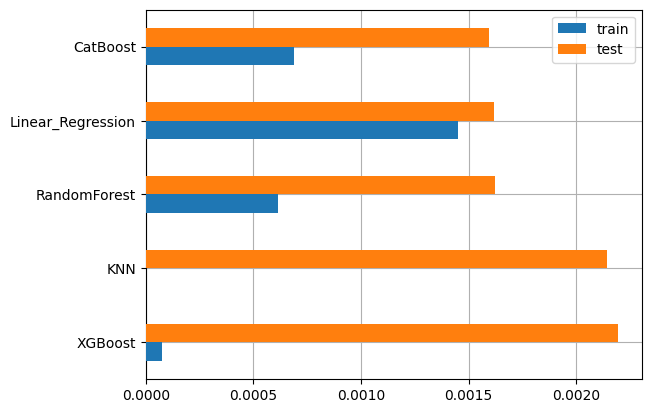

In [62]:
fig, ax = plt.subplots()
mse.sort_values(by='test', ascending=False).plot(kind='barh', ax=ax, zorder=3)
ax.grid(zorder=0)

In [66]:
prediksi = X_test.iloc[:20].copy()
pred_dict = {'y_true':y_test[:20]}
for name, model in model_dict.items():
    pred_dict['prediksi_'+name] = model.predict(prediksi).round(1)
 
pd.DataFrame(pred_dict)

,y_true,prediksi_Linear_Regression,prediksi_KNN,prediksi_RandomForest,prediksi_XGBoost,prediksi_CatBoost
376,14,14.7,14.0,15.1,14.900000,14.9
142,12,11.4,11.2,11.7,11.400000,11.4
43,10,10.3,11.2,10.1,10.000000,10.3
162,11,12.1,10.0,11.9,10.700000,11.4
351,15,15.2,15.4,15.5,15.400000,14.4
120,14,14.8,13.8,15.0,14.800000,14.6
150,9,9.3,10.9,8.6,9.100000,8.8
512,7,6.5,8.6,6.5,7.400000,5.9
190,14,12.8,12.0,12.3,12.500000,12.7
11,13,12.6,12.6,12.5,12.400000,12.4
